# Simulation of Traffic Flow

### Initialising the road

In [82]:
#Importing Libraries
import matplotlib.pyplot as plt 
from matplotlib.animation import PillowWriter
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import numpy as np
import random


def initial(Length,Numberofcars,Seed,Vmax,Queues):

    #Unoccupied road of length L
    Road = np.full(Length,-1)
    #carid stores unique identifiers for each car
    Carid = np.full(Length,0)
    #Colour stores unique colour values for each car
    Colour = np.zeros((Length, 3))
    #used in the extension, to specify hesitant drivers and how much they slow in random events
    Skill = np.full(Numberofcars,0)
    #used in the extension, stores whether cars are able to go over the speed limit
    Aggression = np.full(Numberofcars,0)
    
    
    

    #The seed can either be random or specified when calling the function
    if Seed != "Random":
        random.seed(Seed)

    #Samples random positions in the road for all N cars    
    pos = random.sample(range(Length),Numberofcars) 

    #sorts position so it assigns ids in chronological order
    pos=np.sort(pos)

    
    #Assigns each of the positions and ids with 0 velocity or an incrementing car id, going from 1 to N
    temp = 1
    for i in pos:
        Road[i] = 0
        Carid[i] = temp
        temp += 1

    #mirrors the road array and creates one for colour, so each car has a unique rgb value when plotting
    for i in pos:
        r=random.random()
        g=random.random()
        b=random.random()
        Colour[i]=(r,g,b) 

    #Assigns random values to skill for how much a car slows down in an event, aggression gets random values of 0 or 1
    for i in range(Numberofcars):
        Skill[i] = random.randint(0,Vmax)
        Aggression[i] = random.randint(0,1)



    #Assigns colour values to normal and hesitant cars, going from green(normal) to yellow(hesitant)
    #this is why tempcolour adds a shift, creating this gradient
    #the loop iterates over each possible skill value, seeing which value each car has, and then alters the colour array with this colour

    if Queues != "False":
        tempcolour = (0,1,0)
        rshift = 1/(Vmax+1)
        for j in range(0,Vmax+1):
            tempcolour = np.add(tempcolour, (rshift,0,0))
            for i in range(Numberofcars):
                if Skill[i] == j:
                    Colour[np.where(Carid == (i+1))] = tempcolour

        if Queues == "Aggression" or Queues == "Skill and Aggression":
            for i in range(Numberofcars):
                if Aggression[i] == 1:
                    Colour[np.where(Carid == (i+1))] = (1,0,0)

    return(Road,Colour,Carid,Skill,Aggression)




### Onesec function defines how cars move in 1 time step

In [83]:

def onesec(Length,Road,max_velocity,probability,colour,Carid,Queues,Skill,Aggression):  
    #Defines the updated road, ids and colours after the onesec function is used
    new_Road = -np.ones(Length, dtype=int)
    new_id = -np.zeros(Length, dtype=int)
    new_colour = np.zeros((Length, 3))
    
    for i in range(len(Road)):
    
        #Rule 1
        #moves velocity forward until vmax is reached 
        if Queues == 'False' or Queues == 'Skill':
            #If a space is actually occupied
            if -1 < Road[i] < max_velocity:
                #increases velocity
                Road[i]+=1
        
        #If aggression is enabled, then cars can increase to v_max + 5 in one time step
        if Queues == 'Aggression' or Queues == 'Skill and Aggression':
            #Car does not have aggression trait, regular rules
            if (Aggression[Carid[i]-1]) == 0 and -1 < Road[i] < max_velocity:
                Road[i]+=1
            #car is aggressive
            if (Aggression[Carid[i]-1]) == 1 and -1 < Road[i] < max_velocity:
                Road[i] += max_velocity + 5
                
        #Rule 2
        #if a car is moving 
        if Road[i] >= 0:
            car_separation = 1
            #while loop looks until it finds a car in an occupied space
            while Road[(i + car_separation) % Length] == -1:
                #keeps iterating the separation until it finds a car
                car_separation += 1
            #If the car has more velocity than the separation, its velocity is reduced
            if Road[i] >= car_separation:
                Road[i] = car_separation - 1       

        #Rule 3
        if Queues == 'False' or Queues == 'Aggression':
            #If a car is moving it has probability for a random slow down
            if (Road[i] > 0) and (random.randint(0,100) < probability) and (Aggression[Carid[i]-1] != 1):
                Road[i] += -1
                
        if Queues == 'Skill' or Queues == 'Skill and Aggression':
            #In the extension, hesitant cars slow down more based off of their unique skill value
            #Carid is used to find the index of the current ith car and supply it to skill.
            if (Road[i]> (Skill[Carid[i]-1] -1)) and (random.randint(0,100) < probability) and (Aggression[Carid[i]-1] != 1):
                Road[i] += - Skill[Carid[i]-1]

        
                
        #Rule 4
        if Road[i] >= 0:
            #updates to the new position, using the modulo operator to get a cycled index as the car loops round
            new_position = (i + Road[i]) % Length
            new_Road[new_position] = Road[i]
            new_colour[new_position] = colour[i]
            new_id[new_position] = Carid[i]
            

    Road = new_Road
    colour = new_colour
    Carid=new_id

    return(Road,colour,Carid)




### Plotting one second

In [84]:
def singlesecondplot(Road2d,Length,second,Colour3d):
    #converts single x array into 1s and 0s, allowing the road to be plotted

    xaxis=np.array([])
    yaxis=np.array([])
    colourmap=np.empty((0,3))

    for i in range(Length):
        # If any road value is occupied, add it to the y array with its respective second and x array with relative position
        if Road2d[second][i] != -1:
            xaxis = np.append(xaxis,i)
            yaxis = np.append(yaxis,second)
        #Removes 0s in colour array, so colour can be fed to matplotlib
        if not np.array_equal(Colour3d[second][i], [0, 0, 0]):
            colourmap = np.vstack((colourmap,Colour3d[second][i]))
        
    plt.figure(dpi=120)
    plt.grid()
    plt.xlim(-0.1,Length+0.1)
    plt.scatter(xaxis,yaxis,linestyle="None",marker=">",c=colourmap)
    plt.xlabel('Position')
    plt.ylabel('Time(s)')
    plt.title("Traffic Flow")
    plt.show()
    plt.savefig("singlesecond.png")
    return()




### Animation

In [85]:
def singleframe(Road,Length,Colour):
    'To plot 1 frame, do plt.plot(singleplot(road)[0],singleplot(road)[1])'
    #converts single x array into 1s and 0s, allowing the road to be plotted
    #This function is specifically used for the animation
    xaxis=np.array([])
    yaxis=np.array([])
    colourmap=np.empty((0,3))
    
    for i in range(Length):
        if Road[i] != -1:
            xaxis = np.append(xaxis,i)
            yaxis = np.append(yaxis,1)
        if not np.array_equal(Colour[i], [0, 0, 0]):
            colourmap = np.vstack((colourmap,Colour[i]))

    return(xaxis,yaxis,colourmap)


def animate(Time,max_velocity,Length,Road,eventprob,Colour,Carid,Queues,Skill,Aggression):

    fig = plt.figure(200)
    metadata = dict(title='Movie', artist='Aman')
    writer = PillowWriter(fps=60,metadata=metadata)  

    with writer.saving(fig,"traf.gif",100):
        for j in Time:
            plt.clf()
            plt.xlim(-0.1, Length + 0.1)
            plt.xlabel("Position")
            plt.ylabel("Time")
            plt.title("Time vs Position (Varying Driver Ability)")
            Road, Colour, Carid= onesec(Length,Road,max_velocity,eventprob,Colour,Carid,Queues,Skill,Aggression)
            position , time, colourmap = singleframe(Road,Length,Colour)
            plt.scatter(position,time,linestyle="None",marker=">",c=colourmap)
            writer.grab_frame()  
    return()






### Plotting Time vs Pos for multiple seconds

In [86]:

def multiplesecondplot(Road2d,Length,Time,Colour3d,Queues):
    #Converting x so that it plots time on the y, and position on the x with 1's and 0's
    xaxis=np.array([])
    yaxis=np.array([])
    colourmap=np.empty((0,3))
    
    #plots the line of cars for each second which is why we iterate over time
    for j in Time:
        #now we check each array which defines each second, and convert each array into 1's and 0s specifying the cars location
        for i in range(Length):
            #here we take the array defining the 1st second (j-1) and then iterate over each value in that are([i]) and any values that are occupied are added to the axis
            if Road2d[j-1][i] != -1:
                xaxis = np.append(xaxis,i)
                yaxis = np.append(yaxis,j)
            if not np.array_equal(Colour3d[j-1][i], [0, 0, 0]):
                colourmap = np.vstack((colourmap,Colour3d[j-1][i]))

    title = 0
    #chooses title based off of skill:
    if Queues == "False":
        title = "Time vs Position (Cell Automaton)"
    if Queues == "Skill":
        title = "Time vs Position (Hesitant Driving)"
    if Queues == "Aggression":
        title = "Time vs Position (Aggressive Driving)"
    if Queues == "Skill and Aggression":
        title = "Time vs Position (Hesitant and Aggressive Driving)"

    plt.figure(dpi=200)
    plt.grid()
    plt.xlim(-0.1,Length+0.1)
    #plt.scatter(xaxis,yaxis,linestyle="None",marker=">",s=5)
    plt.scatter(xaxis,yaxis,linestyle="None",marker=">",c=colourmap,s=5)
    plt.xlabel('Position')
    plt.ylabel('Time')
    plt.title(title)
    plt.show()
    plt.savefig("MultipleSecondPlot.png")
    return()




### Flow counter for cars passing end of the road

In [87]:
def flowcheck(Road,Length,Flowcount):
    #This function is used to count how many cars pass the end of the road
    for i in range(len(Road)):
        #checks if a car has enough velocity to surpass the end
        if Road[i]  >= (Length - i):
            #if a car has looped, increase flow counter
            Flowcount +=1
    return(Flowcount)

### Calculates the total journey time for cars to travel length of the road

In [88]:
def journeyt(Journeytime,Looped,End,Road,Length,Carid,j):
    for i in range(len(Road)):
        #checks if a car has enough velocity to surpass the end
        if Road[i]  >= (Length - i) or (Road[i] + 1) >= (Length - i) and End == 'False':
            #if a car has looped set its respective index in looped to 1
            Looped[Carid[i]-1] = 1
    #if all cars have looped, stop checking (end=true) and the journey time is whatever the current time is 
    if np.all(Looped == 1) and End == 'False':
        End = 'True'
        Journeytime = j

    
    return(Journeytime,Looped,End)

### Running Simulation

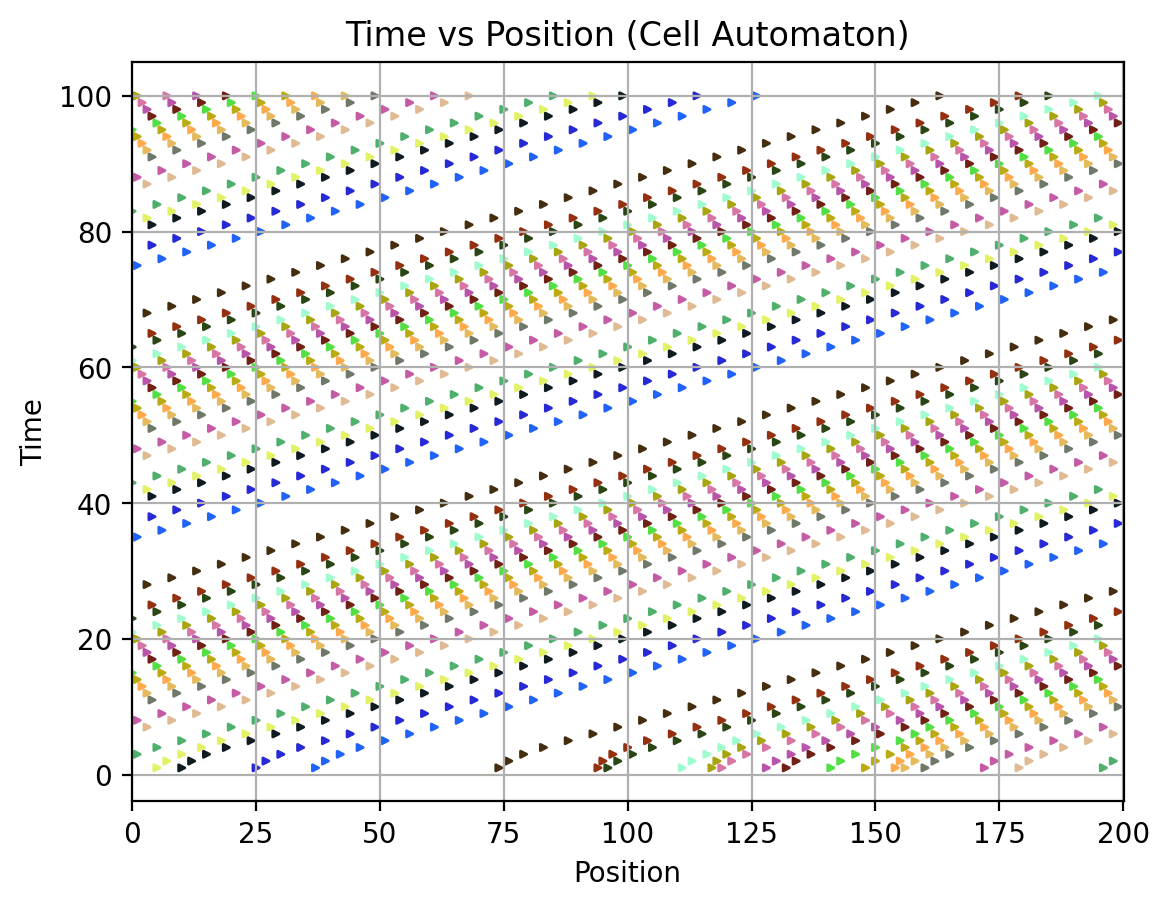

(0.53, 0.1, 2.05)

<Figure size 640x480 with 0 Axes>

In [91]:
def simulate(length,time,number_cars,vmax,event_prob,singleplot,multipleplot,animation,Seed,Queues):

        #2d array of all the roads in one simulation
        x2d=np.empty((0,length))

        #stores all the car ids, in every position, in every second of the road
        carid2d=np.empty((0,length))

        #stores all colour, in every position, in every second of the road
        colour3d=np.empty((0,length,3))

        #how many time steps
        totaltime = np.arange(1,time+1)

        #gets initial variables
        road, colour, car_id, skill,aggression= initial(length,number_cars,Seed,vmax,Queues)

        #used to count flow at the end of the road
        flowcount = 0

        #used to count the total journey time for all cars to complete a cycle of the road
        journeytime = 0
        #stays false until all cars have cycled
        end = 'False'
        #can be 1 or 0 if a car has looped
        looped = np.full(number_cars,0)
        

        for j in totaltime:
                road,colour,car_id= onesec(length,road,vmax,event_prob,colour,car_id,Queues,skill,aggression)
                #stacks/concatenate creates 1 array of the full road, in all time steps
                x2d=np.vstack((x2d,road))
                carid2d=np.vstack((carid2d,car_id))
                colour3d = np.concatenate((colour3d, [colour]), axis=0)
                flowcount = flowcheck(road,length,flowcount)
                journeytime, looped, end = journeyt(journeytime,looped,end,road,length,car_id,j)
        

        #only plots or animates if condition is met
        if singleplot == True:
                singlesecondplot(x2d,length,11,colour3d)
        if animation == True:
                animate(totaltime,vmax,length,road,event_prob,colour,car_id,queues,skill,aggression)
        if multipleplot == True:
                multiplesecondplot(x2d,length,totaltime,colour3d,Queues) 
           
        return(flowcount/time,number_cars/length,journeytime/number_cars)


#seed can take "Random" or any integer value
seed = 43

#Queues can take any of 'False' (Regular cell automaton rules), 'Skill' (hesitant driving), 'Aggression' and 'Skill and Aggression'
queues = 'False'
Road_Length = 200
Time = 100
Number_of_Cars = 20
Max_Velocity = 5
Event_Probability = 0
singleplot = False
multipleplot = True
animation = False


simulate(Road_Length,Time,Number_of_Cars,Max_Velocity,Event_Probability,singleplot,multipleplot,animation,seed,queues)



### Journey Times vs Max Velocity

In [92]:
def journeytimemax(trials):


        velocities = [1,2,3,4,5,6,7,8,9,10,11]
        singleplot = False
        multipleplot = False
        animation = False
        Road_Length = 200
        Time = 400
        Number_of_Cars = 20
        journeyarray = np.array([])
        journeyavg = np.array([])
        yerror = np.array([])
        queues = 'False'
        
        #Loops over all velocitites, and then uses a monte carlo sim to do x trials of the simulation
        #Calculates errors and averages for each velocity value
        for velocity in velocities:
        
                journeytotal = 0
                journeyarray = np.array([])

                for i in range(trials):
                        flowcount, density, Journeytime = simulate(Road_Length,Time,Number_of_Cars,velocity,Event_Probability,singleplot,multipleplot,animation,seed,queues)
                        journeyarray = np.append(journeyarray,Journeytime)
                        journeytotal = np.sum(journeyarray)
                        journeystd = np.std(journeyarray)

                yerror = np.append(yerror,journeystd)
                journeyavg = np.append(journeyavg,journeytotal/trials)
        return(velocities,journeyavg,yerror)

V_max_array, Journey_Time_array,yerror = journeytimemax(5)

#used to fit
def inverse(x,a,b):
    return a/x+b
#used for derivative of fit
def derivativeinverse(x,a,b):
        return -a/((x+b)**2)

popt, pcov = curve_fit(inverse, V_max_array, Journey_Time_array, sigma = yerror)


A, B = popt

perrors = np.sqrt(np.diag(pcov))
A_error, B_error = perrors

xfit = np.linspace(min(V_max_array), max(V_max_array), 100)
yfit = inverse(xfit,A,B)

r_squared = r2_score(Journey_Time_array, inverse(V_max_array,A,B))

derivative = derivativeinverse(xfit, A, B)



print("R^2 = ", r_squared)
print("A = ", A, "±", A_error)
print("B = ", B, "±", B_error)
print("average error", np.sum(yerror)/len(yerror))
print(yerror)



plt.figure(dpi=120)
plt.grid()
plt.scatter(V_max_array,Journey_Time_array,linestyle="None",marker="o")
plt.errorbar(V_max_array, Journey_Time_array, yerr=yerror, fmt="o")
plt.plot(xfit, yfit, 'r-', label = "Inverse Function Fit")
plt.plot(xfit, derivative ,color = 'green',label = "Derivative")
plt.xlabel(r"$v_{\mathrm{max}}$")
plt.ylabel('Average Journey Time per Car')
plt.yticks(np.linspace(-5, 10, 15))
plt.xticks(np.linspace(0, 11, 12))
plt.legend()
plt.title("Journey Time vs Maximum Velocity")
plt.show()



c:\Users\aman\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

### Journey Time vs Event Probability

In [31]:
def journeytimeevent(trials):


        events = np.array([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,86,87,88,89])
        singleplot = False
        multipleplot = False
        animation = False
        Road_Length = 200
        Time = 400
        Number_of_Cars = 20
        Max_Velocity = 5 
        journeyarray = np.array([])
        journeyavg = np.array([])
        journeystd = np.array([])
        yerror = np.array([])
        queues = 'False'

        #Loops over all events, and then uses a monte carlo sim to do x trials of the simulation
        #Calculates errors and averages for each velocity value
        for event in events:
        
                journeytotal = 0
                journeyarray = np.array([])
                for i in range(trials):
                        flowcount, density, Journeytime = simulate(Road_Length,Time,Number_of_Cars,Max_Velocity,event,singleplot,multipleplot,animation,seed,queues)
                        journeyarray = np.append(journeyarray,Journeytime)
                        journeytotal = np.sum(journeyarray)
                        journeystd = np.std(journeyarray)
                journeyavg = np.append(journeyavg,journeytotal/trials)
                yerror = np.append(yerror,journeystd)

        return(events,journeyavg,yerror)



events, Journey_Time_array,yerror = journeytimeevent(100)

def inverse2(x,a,b,c):
    return ((a/(-x+b))+c)


def derivativeinverse2(x,a,b):
    return -a/((x-b)**2)
events=events/10
popt, pcov = curve_fit(inverse2, events, Journey_Time_array,p0=[80,90,3],sigma=yerror)


A, B, C= popt

perrors = np.sqrt(np.diag(pcov))
A_error, B_error,C_error = perrors

xfit = np.linspace(min(events), max(events), 100)
yfit = inverse2(xfit,A,B,C)

r_squared = r2_score(Journey_Time_array, inverse2(events,A,B,C))

derivative2 = derivativeinverse2(xfit, A, B)

print("R^2 = ", r_squared)
print("A = ", A, "±", A_error)
print("B = ", B, "±", B_error)
print("C = ", C, "±", C_error)
print("average error", np.sum(yerror)/len(yerror))
print(yerror)

plt.figure(dpi=120)

plt.grid()
plt.scatter(events,Journey_Time_array,linestyle="None",marker="o")
plt.plot(xfit, yfit, 'r-',label = "Inverse Function Fit")
plt.errorbar(events, Journey_Time_array, yerr=yerror, fmt="o")
plt.gca().invert_xaxis()
plt.xlabel('Event Probability (p)')
plt.ylabel('Average Journey Time per Car (T)')
plt.yticks(np.linspace(-10, 15, 26))
plt.xticks(np.linspace(10, 1, 10))
plt.plot(xfit, derivative2 ,color = 'green',label = "Derivative")
plt.legend()
plt.title("Journey Time vs Event Probability")

plt.show()

KeyboardInterrupt: 

### Journey Time vs Event Probability (Multiple Velocities)

In [ ]:
def journeytimemultiple(trials):


        
        velocities = np.array([4,5,6,7,8])
        singleplot = False
        multipleplot = False
        animation = False
        Road_Length = 200
        Time = 400
        Number_of_Cars = 20
        #colours for each individual velocity plot
        colourarray = ['b','g','r','c','m']
        #index is used to iterate the colours
        index=0
        queues = 'False'
        plt.figure(dpi=120)
        plt.grid()

        #Loops over all events, and then uses a monte carlo sim to do x trials of the simulation
        #Calculates errors and averages for each velocity value
        #Then loops over all velocities to get 5 different plots for different velocity values
        for velocity in velocities: 
                events = np.array([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,82,84,86,88,89])
                journeyarray = np.array([])
                journeyavg = np.array([])
                journeystd = np.array([])
                yerror = np.array([])
                for event in events:
        
                        journeytotal = 0
                        journeyarray = np.array([])
                        for i in range(trials):
                                flowcount, density, Journeytime = simulate(Road_Length,Time,Number_of_Cars,velocity,event,singleplot,multipleplot,animation,seed,queues)
                                journeyarray = np.append(journeyarray,Journeytime)
                                journeytotal = np.sum(journeyarray)
                                journeystd = np.std(journeyarray)
                        journeyavg = np.append(journeyavg,journeytotal/trials)
                        yerror = np.append(yerror,journeystd)
                events = events/10
                def inverse2(x,a,b,c):
                        return ((a/(-x+b))+c)

                popt, pcov = curve_fit(inverse2, events, journeyavg,p0=[10,10,3],sigma = yerror)

                A, B, C= popt
                colour = colourarray[index]
                index +=1
                perrors = np.sqrt(np.diag(pcov))
                A_error, B_error,C_error = perrors

                xfit = np.linspace(min(events), max(events), 100)
                yfit = inverse2(xfit,A,B,C)

                r_squared = r2_score(journeyavg, inverse2(events,A,B,C))

                label = str(velocity)
                plt.plot(xfit, yfit,color = colour , label = label)
                plt.legend(title = r"$v_{\mathrm{max}}$")
                plt.errorbar(events, journeyavg, yerr=yerror,fmt = 'o',color = colour)
                print("For a maximum velocity of ",velocity,":")
                print("R^2 = ", r_squared)
                print("A = ", A, "±", A_error)
                print("B = ", B, "±", B_error)
                print("C = ", C, "±", C_error)
        plt.xlabel('Event Probability (p/10)')
        plt.ylabel('Average Journey Time per Car (T)')
        plt.gca().invert_xaxis()
        plt.title("Journey Time vs Event Probability (Changing Max Velocity)")
        plt.yticks(np.linspace(0, 14, 15))
        plt.xticks(np.linspace(9, 1, 9))
        return(events,journeyavg,yerror)



events, Journey_Time_array,yerror = journeytimemultiple(100)






### Traffic Flow vs Traffic Density for different driving styles

KeyboardInterrupt: 

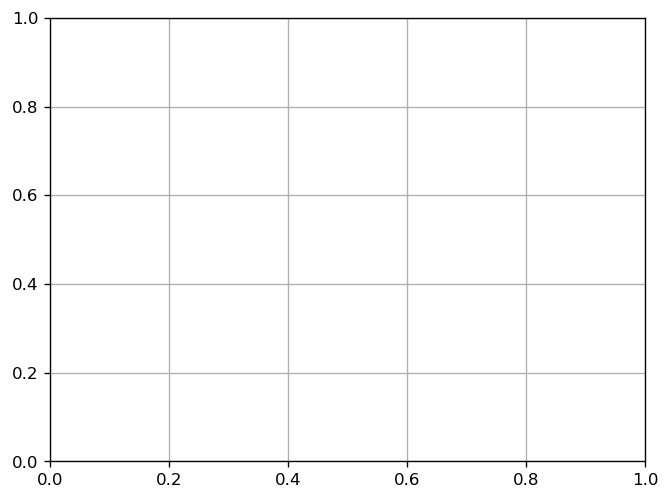

In [32]:
def flowvsdensity(numbersteps,trials):

        #number_cars_steps = int((Road_Length/numbersteps)) * np.arange(1,numbersteps)

        singleplot = False
        multipleplot = False
        animation = False
        seed = 'Random'
        queues = 'False'
        Time = 200
        Max_Velocity = 5
        Road_Length = 200
        colourarray = ['b','g','r','c','m']
        index=0
        queues = ['False','Skill','Aggression']
        labels = ['Normal','Hesitant','Aggressive']
        plt.figure(dpi=120)
        plt.grid()
        #Loops over all queue types, and then uses a monte carlo sim to do x trials of the simulation
        #Calculates errors and averages for each velocity value
        #Then loops over all velocities to get 5 different plots for different velocity values
        for queue in queues:
                number_cars_steps=[5,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76,80,84,88,92,95,100,110,120,130,140,150,160,170,180,190]
                flowavg = np.array([])
                densearray = np.array([])
                flow = np.array([])
                yerror = np.array([]) 
                for number in number_cars_steps:
                        flowtotal = 0
                        flow = np.array([])
                        for i in range(trials):
                                flowcount, density, journeytime = simulate(Road_Length,Time,number,Max_Velocity,Event_Probability,singleplot,multipleplot,animation,seed,queue)
                                flow = np.append(flow,flowcount)
                                flowtotal = np.sum(flow)
                                flowstd = np.std(flow)
                        flowavg = np.append(flowavg,flowtotal/trials)
                        densearray = np.append(densearray,density)
                        yerror = np.append(yerror,flowstd)
                print(np.max(flowavg))
                colour = colourarray[index]
 
                def skew_gauss(x, amp, loc, stdev_left, stdev_right, offset):
                        return offset + amp * np.where(x <= loc, np.exp(-(x - loc)**2 / (2 * stdev_left**2)), np.exp(-(x - loc)**2 / (2 * stdev_right**2)))


                popt, pcov = curve_fit(skew_gauss, densearray, flowavg,sigma = yerror)

                amp, loc, stdev_left, stdev_right, offset = popt

                perrors = np.sqrt(np.diag(pcov))
                amp_error, loc_error, stdev_left_error, stdev_right_error, offset_error = perrors

                xfit = np.linspace(min(densearray), max(densearray), 100)
                yfit = skew_gauss(xfit, amp, loc, stdev_left, stdev_right, offset)
                plt.plot(xfit, yfit, label = labels[index],color = colour)
                plt.errorbar(densearray,flowavg, yerr=yerror, fmt="o",color = colour)
                plt.legend(title="Driving Style")

                index +=1
                r_squared = r2_score(flowavg, skew_gauss(densearray, amp, loc, stdev_left, stdev_right, offset))
                
                #print("A = ", A, "±", A_error)
                #print("B = ", B, "±", B_error)
                print("Driving Style:", queue)
                print("R^2 = ", r_squared)
                print("maximum of fit (from curve fit function)=",loc,amp)
                print("minimum of fit (from data)=",np.max(flowavg))
                print("average error", np.sum(yerror)/len(yerror))
                print("error",yerror)
        plt.xlabel('Density (N/L)')
        plt.ylabel('Traffic Flow per Time Step')
        plt.title("Traffic Flow vs Number Density of Cars")
        return(densearray,flowavg,yerror)

numberdensity,averageflow,averageflowerror = flowvsdensity(10,140)













### Flow Peak

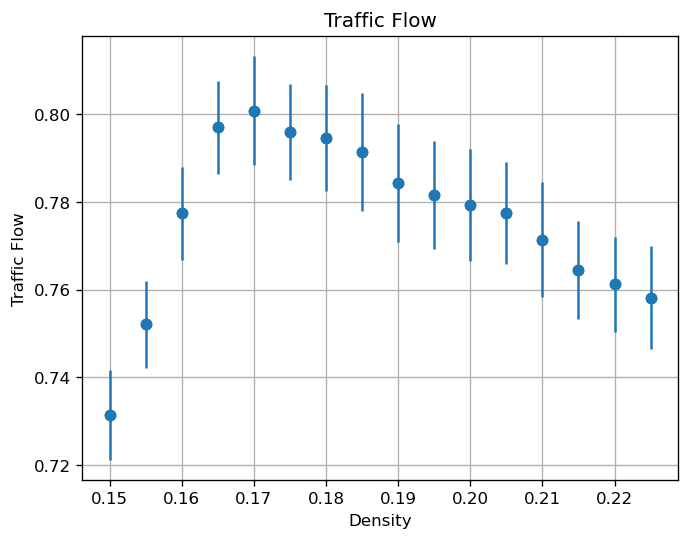

In [30]:
def flowvsdensity(numbersteps,trials):

        number_cars_steps = int((Road_Length/numbersteps)) * np.arange(1,numbersteps)
        number_cars_steps=[30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]
        flowavg = np.array([])
        densearray = np.array([])
        flow = np.array([])
        yerror = np.array([])
        singleplot = False
        multipleplot = False
        animation = False
        Event_Probability = 0.2
        Max_Velocity = 5
        Time = 200
        Queues = 'False'
        seed = 'Random'
        for number in number_cars_steps:
        
                flowtotal = 0
                flow = np.array([])

                for i in range(trials):
                        flowcount, density, journeytime = simulate(Road_Length,Time,number,Max_Velocity,Event_Probability,singleplot,multipleplot,animation,seed,Queues)
                        flow = np.append(flow,flowcount)
                        flowtotal = np.sum(flow)
                        flowstd = np.std(flow)

                flowavg = np.append(flowavg,flowtotal/trials)
                densearray = np.append(densearray,density)
                yerror = np.append(yerror,flowstd)

        return(densearray,flowavg,yerror)

numberdensity,averageflow,averageflowerror = flowvsdensity(10,100)
plt.figure(dpi=120)
plt.grid()
plt.scatter(numberdensity,averageflow,linestyle="None",marker="o")
plt.errorbar(numberdensity,averageflow, yerr=averageflowerror, fmt="o")
plt.xlabel('Density (N/L)')
plt.ylabel('Traffic Flow per Time Step')
plt.title("Traffic Flow vs Number Density of Cars (Peak)")
plt.show()
